# Segementation Study

**Context**: we gather social media accounts that look similar and that are relevant to study fashion. It is crucial for us to distinguish the type of users to understand their behavior. 

For instance, our segmentation is currently based on the amount of followers an account has:

- A **mainstream** account has *at most 12,000* followers
- A **trendy** account has *between 12,000 and 40,000* followers
- An **edgy** account has *more than 40,000* followers

In [1]:
from snowflake_utils import get_connector, query
from queries import clean_authors_query, authors_posts_summary_logged_query, authors_enriched_query

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from umap import UMAP

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

conn = get_connector()

/home/martin/Bureau/heuritech/ds-fashion-insights-takehome/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MAINSTREAM = 'mainstream'
TRENDY = 'trendy'
EDGY = 'edgy'

## Evaluate the quality of a segmentation 

#### What kind of analysis would you do to evaluate the quality of **a** segmentation methodology?


In [3]:
def get_segment_idx(nb_followers): 
    if nb_followers <= 12000: 
        return 0
    elif nb_followers <= 40000:
        return 1
    else: 
        return 2
     
segment_idx_to_name = {0: MAINSTREAM, 1: TRENDY, 2: EDGY}

In [4]:
authors_df = query(conn, clean_authors_query)

In [5]:
authors_df['segment_idx'] = authors_df.NB_FOLLOWERS.apply(get_segment_idx)
authors_df['segment_name'] = authors_df.segment_idx.apply(lambda idx: segment_idx_to_name[idx])

In [6]:
authors_df.head()

,AUTHORID,NB_FOLLOWS,NB_FOLLOWERS,NB_FOLLOWERS_LN1P,FASHION_INTEREST_SEGMENT,segment_idx,segment_name
0,323798338,1100,640,6.463029,False,0,mainstream
1,49781027964,1,58,4.077537,False,0,mainstream
2,1683100126,2919,7184,8.879751,False,0,mainstream
3,1455851258,6553,2973,7.997663,False,0,mainstream
4,27709749,4547,16509,9.711722,False,1,trendy


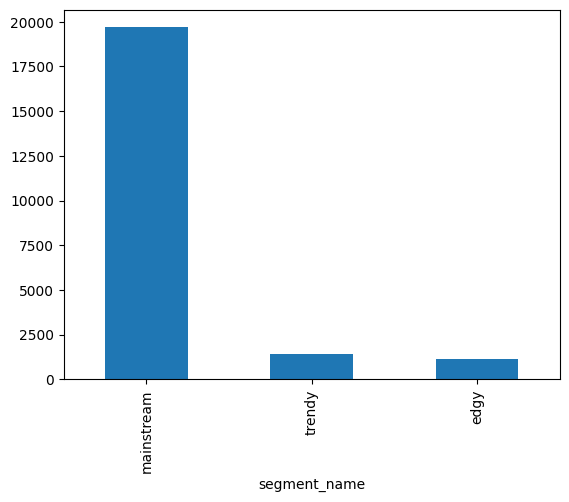

In [7]:
authors_df.segment_name.value_counts().plot(kind='bar')
plt.show()

In [8]:
authors_posts_summary_df = query(conn, authors_posts_summary_logged_query)
authors_posts_summary_df.head()

,AUTHORID,AVG_LIKES,AVG_LIKES_LN1P,VAR_LIKES,AVG_COMMENTS,AVG_COMMENTS_LN1P,VAR_COMMENTS,NB_POSTS,NB_POSTS_LN1P,NB_IMAGES,NB_IMAGES_LN1P,NB_DAYS_SINCE_FIRST_POST
0,201341523,52.383459,3.977501,48687.632149,18.263158,2.958194,149.755981,133,4.897840,133,4.897840,745
1,32986050,34.250000,3.562466,200.671687,2.130952,1.141337,7.006741,84,4.442651,84,4.442651,749
2,1527674028,5.404396,1.856985,19.100421,0.298901,0.261519,0.862003,455,6.122493,455,6.122493,749
3,2255022767,10.382979,2.432119,70.934438,1.622824,0.964252,11.150098,517,6.249975,517,6.249975,748
4,5035051230,3.754998,1.559196,28.897620,0.181776,0.167018,0.410198,2151,7.674153,2151,7.674153,749


In [9]:
merged_df = authors_df.merge(authors_posts_summary_df, how='inner', on='AUTHORID')
merged_df.head()

,AUTHORID,NB_FOLLOWS,NB_FOLLOWERS,NB_FOLLOWERS_LN1P,FASHION_INTEREST_SEGMENT,segment_idx,segment_name,AVG_LIKES,AVG_LIKES_LN1P,VAR_LIKES,AVG_COMMENTS,AVG_COMMENTS_LN1P,VAR_COMMENTS,NB_POSTS,NB_POSTS_LN1P,NB_IMAGES,NB_IMAGES_LN1P,NB_DAYS_SINCE_FIRST_POST
0,323798338,1100,640,6.463029,False,0,mainstream,10.714286,2.460809,32.514286,2.666667,1.299283,6.433333,21,3.091042,21,3.091042,749
1,49781027964,1,58,4.077537,False,0,mainstream,0.656489,0.504700,0.581092,0.053435,0.052056,0.066353,131,4.882802,131,4.882802,749
2,1683100126,2919,7184,8.879751,False,0,mainstream,9.206573,2.323032,26.170427,0.665102,0.509886,1.806163,639,6.461468,639,6.461468,749
3,1455851258,6553,2973,7.997663,False,0,mainstream,6.019231,1.948654,639.454971,1.054196,0.719885,5.420876,570,6.347389,572,6.350886,748
4,27709749,4547,16509,9.711722,False,1,trendy,0.000000,0.000000,0.000000,34.500000,3.569533,612.500000,2,1.098612,2,1.098612,258


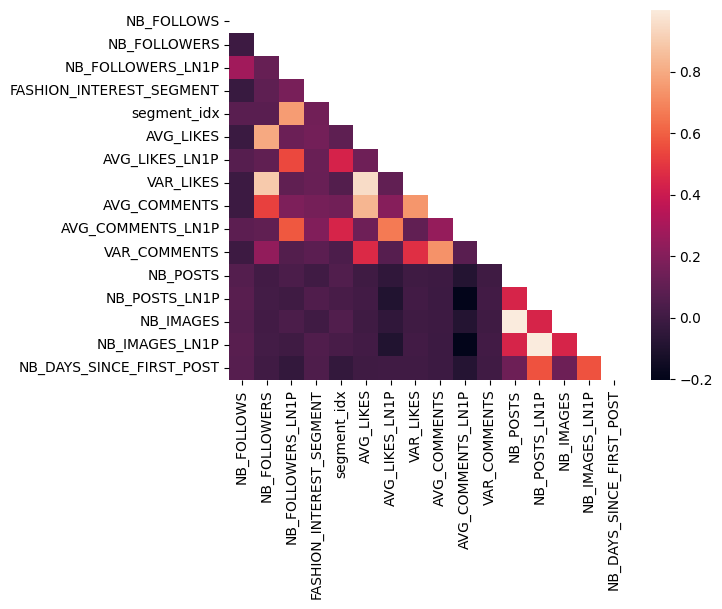

In [10]:
corr_df = merged_df.drop(columns=['AUTHORID', 'segment_name']).corr()
mask = np.ones(corr_df.shape)

for i in range(corr_df.shape[0]):
    for j in range(corr_df.shape[1]): 
        if i > j:
            mask[i, j] = 0.

sns.heatmap(corr_df, mask=mask)
plt.show()

We observe that the number of followers shows a correlation with the average number of comments and likes. Let's examine a box plot of the number of likes and comments across the different segments

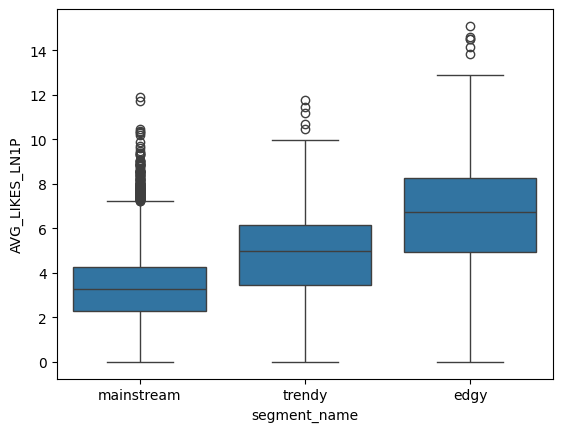

In [11]:
sns.boxplot(x='segment_name', y='AVG_LIKES_LN1P', data=merged_df)
plt.show()

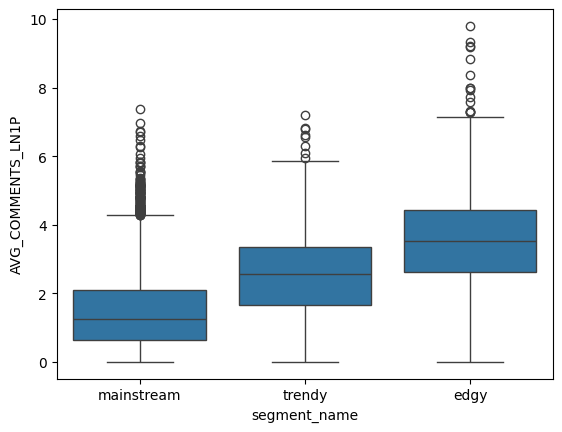

In [12]:
sns.boxplot(x='segment_name', y='AVG_COMMENTS_LN1P', data=merged_df)
plt.show()

We observe that edgy accounts exhibit higher engagement compared to trendy accounts, which in turn show better engagement than mainstream accounts.
But mainstream account show a lot more outliers than trendy or edgy accounts.

#### What biases can you identify in the panel creation or in the accounts selection that might distort insights and how would you correct them?

One potential bias in the panel creation or account selection process is the presence of extreme values, which can distort distributions and affect segmentation quality. In the context of social media influence, these outliers often represent highly impactful individuals, making their exclusion problematic. Rather than removing them outright, I chose to apply a log transformation to normalize the distribution while preserving their relative importance. This approach smooths discrepancies and allows for more meaningful comparisons across different account sizes.   

Alternatively, a stricter approach could involve filtering out these extreme values entirely, but this might lead to an incomplete representation of the influencer landscape, depending on the business objective.

#### What do you think about the current segmentation?

Since I not very familiar to fashion concepts, I ask chatGPT about it.
From a mode (fashion) perspective, the discrimination between "mainstream," "trendy," and "edgy" influences can be understood through their relationship to cultural norms, adoption cycles, and risk-taking in style.
1. Mainstream Fashion: Represents widely accepted and broadly worn styles, often dictated by major fashion houses, retailers, and media.
    - Timeless or classic elements (e.g., well-tailored suits, denim, neutral palettes).
    - Accessible and practical for a wide audience.
    - Seen in large retailers (Zara, H&M, Uniqlo) and major luxury brands' core collections (Louis Vuitton, Ralph Lauren).
    - _Influence Source_: Traditional fashion authorities (runways, celebrities, heritage brands).
    - _Adoption Curve_: Mass adoption, longevity in trends.

2. Trendy Fashion: Captures the styles that are currently gaining popularity, often driven by social media, influencers, and fast fashion.

    - Defined by rapid shifts and viral moments.
    - May be experimental but within a socially acceptable range.
    - _Examples_: Y2K revival, oversized blazers, chunky sneakers.
    - _Influence Source_: Influencers, social media (TikTok, Instagram), street style, microtrends.
    - _Adoption Curve_: Peaks quickly but fades fast (e.g., "dopamine dressing" or "Barbiecore").

3. Edgy Fashion: Challenges conventions by embracing alternative aesthetics, countercultural elements, or avant-garde concepts.
    - Often darker, more structural, or deconstructed looks.
    - Incorporates subcultural influences (punk, goth, grunge, cyberpunk).
    - Designers like Rick Owens, Comme des Garçons, Yohji Yamamoto epitomize this.
    - _Influence Source_: Underground movements, niche communities, rebellious aesthetics.
    - _Adoption Curve_: Niche and cult-following, but sometimes trickles into trendy or even mainstream fashion (e.g., punk elements in high fashion).

The proposed approach suggests a segmentation that follows an intuitive logic: mainstream represents the largest share, followed by a smaller trendy group, and an even more limited edgy segment. This aligns with reality, where dominant fashion is the most visible and widely adopted, while more avant-garde styles remain niche.

However, this segmentation relies only on the number of followers, a metric that measures popularity rather than actual fashion influence. In the fashion world, there is a common tendency to overestimate the importance of edgy styles. Artistic circles often perceive avant-garde fashion as more influential than it actually is, partly because they focus on it more. In reality, mainstream fashion remains dominant—it is more accessible, less expensive, and widely distributed.

The trendy segment, on the other hand, occupies a middle ground, constantly shifting with the rise and fall of trends. What is trendy today often becomes mainstream tomorrow. This transition can happen quickly, with some trends taking only a few months to be absorbed into the mainstream. In contrast, influences from the avant-garde take much longer to trickle down—what is considered edgy today may take years before becoming widely adopted.

This is why, while the proposed segmentation is simple and easy to understand, it does not accurately reflect the business reality of fashion. A more refined analysis would need to go beyond follower count and incorporate elements such as actual influence on trends and the time dynamics between edgy, trendy, and mainstream.

#### What is your take on the way the information is stored?

With a rule as simple as splitting on a column, partitioning or sharding could be a solution to explicitly enforce physical data segmentation. However, there is no proper partitioning in either of the provided tables, `MART_AUTHORS` or `MART_AUTHORS_SEGMENTATIONS`. While this is acceptable given the provided data volume—since segmentation can be computed at query time—it does not explicitly reflect the business logic at the presentation layer.

Another approach could be deriving a categorical feature from `NB_FOLLOWERS` to store the segment directly as an attribute. This would make queries more efficient and self-explanatory while allowing for more complex segmentation rules beyond simple thresholding. However, this would require clear governance on how and when the segmentation is updated.

## Advance Segmentation Techniques

We would like to push our segmentation one step further. The current methodology refrains us from spotting interesting (sub)categories of accounts like fashion enthusiasts, luxury, sportswear, etc. Several families of methods can be considered to improve this methodology: 

- Statistical approach
- Machine Learning approaches (supervised and/or unsupervised)
- Hybrid approach combining deterministic rules and machine learning

You are free to exploit the author database the way you want. You can also generate new tables to develop your approach.

In [13]:
authors_enriched_df = query(conn, authors_enriched_query).fillna(0.)

author_ids = authors_enriched_df.iloc[:, 1]
author_general_df = authors_enriched_df.iloc[:, 1:18]
labels_occurences_df = authors_enriched_df.iloc[:, 18:]

#### Topic Extraction with NMF

With this approach, I will try to extract a dominant topic for each author. I will chose to define 10 topics and extract them with NMF.
The topics are defined by a list of label names and the weight of each label name in the topic. A given label name can be in multiple topics.

In [14]:
labels_occurences_df.head()

,'adidas','alexandermcqueen','allover','bag','balencia','balenciaga','basicdenim','belt','bigpadded','boots',...,'tweed','umbrella','underpants','veja','velvet','vinyl','wax','wristlet','ysl','zebra'
0,2.0,0.0,1.0,4.0,0.0,0.0,9.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,9.0,0.0,0.0
1,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
4,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
feature_names = labels_occurences_df.columns

tfidf = TfidfTransformer()
label_author_matrix_tfidf = tfidf.fit_transform(labels_occurences_df)

n_topics = 10

nmf = NMF(n_components=n_topics, random_state=42, max_iter=500)
nmf_topics = nmf.fit_transform(label_author_matrix_tfidf)
nmf_components = nmf.components_

In [16]:
top_n = 10
for topic_idx, topic in enumerate(nmf_components):
    print(f"Topic #{topic_idx + 1}:")
    top_labels_idx = topic.argsort()[-top_n:][::-1]  # Indices of top N labels
    top_labels = [feature_names[i] for i in top_labels_idx]  # Label names of top N labels
    top_weights = topic[top_labels_idx]  # Weights (importance) of the top labels
    
    for label, weight in zip(top_labels, top_weights):
        print(f"{label}: {weight:.3f}")
    print("\n")

Topic #1:
'plain': 7.296
'leather': 0.276
'neckwear': 0.233
'skirt': 0.134
'fur': 0.132
'velvet': 0.066
'linen': 0.048
'satin': 0.048
'pinstripes': 0.041
'solerubber': 0.026


Topic #2:
'noheel': 2.410
'sneakers': 2.371
'heelflat': 2.306
'shoes': 2.090
'solerubber': 2.044
'closedback': 2.030
'toeround': 1.890
'closurelacing': 1.788
'sneakerlowtop': 1.656
'sneakerslimsole': 1.508


Topic #3:
'bag': 6.327
'umbrella': 0.774
'clock': 0.602
'shoes': 0.572
'neckwear': 0.273
'noheel': 0.149
'toeround': 0.114
'boots': 0.110
'sneakers': 0.099
'heelflat': 0.074


Topic #4:
'shoes': 4.212
'sandals': 2.029
'boots': 1.864
'pumps': 1.502
'toepointy': 1.315
'toealmond': 1.313
'heelchunky': 1.297
'heelhigh': 1.127
'toeround': 1.103
'sandalankle': 0.910


Topic #5:
'wristlet': 6.753
'bra': 0.593
'underpants': 0.317
'shorts': 0.170
'skirt': 0.128
'shoes': 0.123
'belt': 0.094
'combi': 0.044
'socks': 0.029
'pants': 0.029


Topic #6:
'eyewear': 5.748
'neckwear': 0.165
'checked': 0.139
'umbrella': 0.114
'st

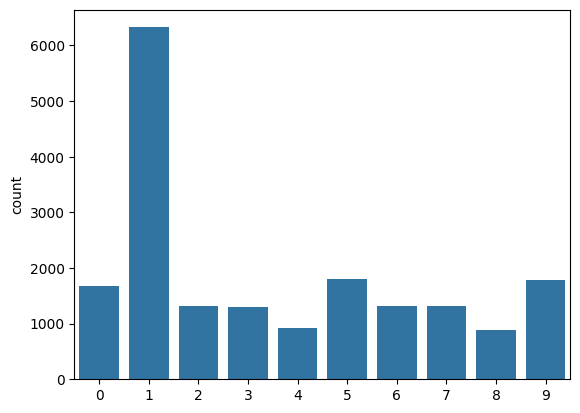

In [17]:
author_labels = np.argmax(nmf_topics, axis=1)
sns.countplot(x=author_labels)
plt.show()

It seems to have a majority of shoe-related content creators in this dataset

#### Authors Clustering

In [18]:
author_general_df.head()

,NB_FOLLOWS,NB_FOLLOWERS,NB_FOLLOWERS_LN1P,FASHION_INTEREST_SEGMENT,LABEL_ENTROPY,NB_DISTINCT_LABELS,AVG_LIKES,AVG_LIKES_LN1P,VAR_LIKES,AVG_COMMENTS,AVG_COMMENTS_LN1P,VAR_COMMENTS,NB_POSTS,NB_POSTS_LN1P,NB_IMAGES,NB_IMAGES_LN1P,NB_DAYS_SINCE_FIRST_POST
0,430,312,5.746203,False,3.438237,62,11.949640,2.561068,121.164112,1.172662,0.775953,2.506204,139,4.941642,139,4.941642,749
1,99,54,4.007333,False,1.721905,9,2.833333,1.343735,11.158192,0.383333,0.324496,0.681073,60,4.110874,60,4.110874,749
2,1384,509,6.234411,False,1.767761,7,45.750000,3.844814,248.197368,2.950000,1.373716,10.050000,20,3.044522,20,3.044522,680
3,1024,2375,7.773174,False,3.040729,23,218.285714,5.390376,140656.904762,6.428571,2.005334,66.619048,7,2.079442,7,2.079442,457
4,1283,4760,8.468213,False,2.058217,11,31.291667,3.474809,364.294014,2.208333,1.165751,18.505282,72,4.290459,72,4.290459,749


We have seen during the EDA that for some features, it is better to use their log representation.

In [19]:
feature_selected_df = (
    author_general_df
    .drop(columns=['NB_FOLLOWS', 'AVG_LIKES', 'AVG_COMMENTS', 'NB_POSTS', 'NB_IMAGES'])
    .drop(columns=['FASHION_INTEREST_SEGMENT']) # categorical feature
)
print('shape', feature_selected_df.shape)
feature_selected_df.head()

shape (18685, 11)


,NB_FOLLOWERS,NB_FOLLOWERS_LN1P,LABEL_ENTROPY,NB_DISTINCT_LABELS,AVG_LIKES_LN1P,VAR_LIKES,AVG_COMMENTS_LN1P,VAR_COMMENTS,NB_POSTS_LN1P,NB_IMAGES_LN1P,NB_DAYS_SINCE_FIRST_POST
0,312,5.746203,3.438237,62,2.561068,121.164112,0.775953,2.506204,4.941642,4.941642,749
1,54,4.007333,1.721905,9,1.343735,11.158192,0.324496,0.681073,4.110874,4.110874,749
2,509,6.234411,1.767761,7,3.844814,248.197368,1.373716,10.050000,3.044522,3.044522,680
3,2375,7.773174,3.040729,23,5.390376,140656.904762,2.005334,66.619048,2.079442,2.079442,457
4,4760,8.468213,2.058217,11,3.474809,364.294014,1.165751,18.505282,4.290459,4.290459,749


In [20]:
feature_selected_df.isnull().sum()

NB_FOLLOWERS                0
NB_FOLLOWERS_LN1P           0
LABEL_ENTROPY               0
NB_DISTINCT_LABELS          0
AVG_LIKES_LN1P              0
VAR_LIKES                   0
AVG_COMMENTS_LN1P           0
VAR_COMMENTS                0
NB_POSTS_LN1P               0
NB_IMAGES_LN1P              0
NB_DAYS_SINCE_FIRST_POST    0
dtype: int64

In [21]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(feature_selected_df)

In [22]:
umap_reducer_2d = UMAP(n_components=2, n_jobs=-1)
X_umap_2d = umap_reducer_2d.fit_transform(scaled_X)

/home/martin/Bureau/heuritech/ds-fashion-insights-takehome/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


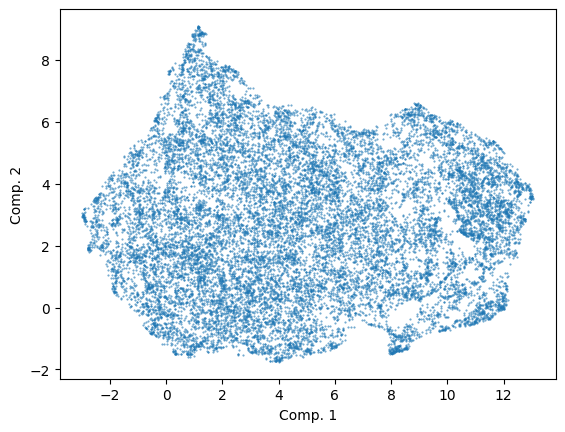

In [23]:
plt.scatter(
    X_umap_2d[:, 0]
    , X_umap_2d[:, 1]
    , alpha=0.7
    , marker='.'
    , s=1
)

plt.xlabel('Comp. 1')
plt.ylabel('Comp. 2')
plt.show()

In [24]:
inertias = []
n_clusters = range(3, 22, 2)
for n_cluster in n_clusters: 
    kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=5) 
    kmeans.fit(scaled_X)
    inertias.append(kmeans.inertia_)

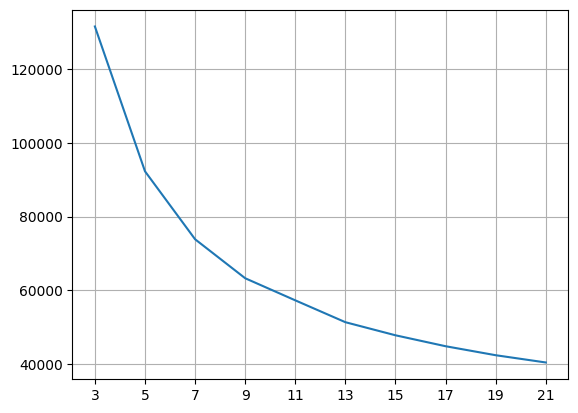

In [25]:
plt.plot(n_clusters, inertias)
plt.grid(True)
plt.xticks(n_clusters)
plt.show()

There seems to be a diminushing return at 11 clusters.

In [26]:
kmeans = KMeans(n_clusters=11, random_state=42, n_init=5) 
kmeans.fit(scaled_X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_


/home/martin/Bureau/heuritech/ds-fashion-insights-takehome/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


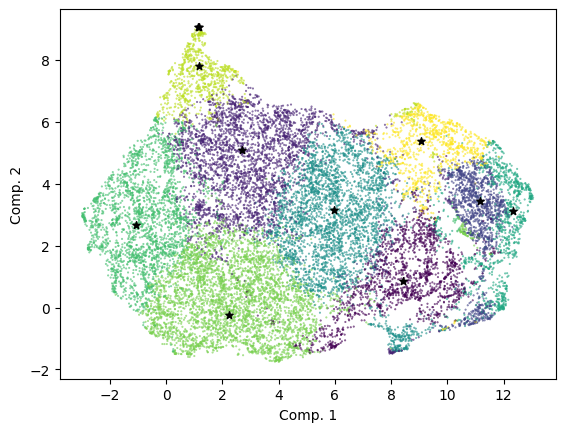

In [27]:
centroids_2D = umap_reducer_2d.transform(centroids)
plt.scatter(
    X_umap_2d[:, 0]
    , X_umap_2d[:, 1]
    , c=labels
    , alpha=0.7
    , marker='.'
    , s=1
)

plt.scatter(
    centroids_2D[:, 0]
    , centroids_2D[:, 1]
    , c='black'
    # , alpha=0.7
    , marker='*'
    , s=30
)

plt.xlabel('Comp. 1')
plt.ylabel('Comp. 2')
plt.show()

#### Clustering on embedded features

In [28]:
import pandas as pd
components = [f'Comp_{i}' for i in range(10)]
embed_df = pd.DataFrame(nmf_topics, columns=components)
embed_df.head()

,Comp_0,Comp_1,Comp_2,Comp_3,Comp_4,Comp_5,Comp_6,Comp_7,Comp_8,Comp_9
0,0.059825,0.041257,0.005193,0.021732,0.013047,0.031141,0.019575,0.037198,0.016015,0.064480
1,0.024484,0.000000,0.129440,0.000000,0.006728,0.054683,0.016427,0.006516,0.000000,0.034603
2,0.026126,0.000000,0.000965,0.000000,0.029240,0.076562,0.038701,0.000000,0.003088,0.072023
3,0.038165,0.085898,0.000000,0.000000,0.047158,0.028691,0.013441,0.026270,0.000000,0.027796
4,0.043041,0.000000,0.058499,0.000000,0.009744,0.051366,0.061777,0.024207,0.000000,0.066877


In [29]:
hybrid_df = pd.concat([feature_selected_df, embed_df], axis=1)
hybrid_df.head()

,NB_FOLLOWERS,NB_FOLLOWERS_LN1P,LABEL_ENTROPY,NB_DISTINCT_LABELS,AVG_LIKES_LN1P,VAR_LIKES,AVG_COMMENTS_LN1P,VAR_COMMENTS,NB_POSTS_LN1P,NB_IMAGES_LN1P,...,Comp_0,Comp_1,Comp_2,Comp_3,Comp_4,Comp_5,Comp_6,Comp_7,Comp_8,Comp_9
0,312,5.746203,3.438237,62,2.561068,121.164112,0.775953,2.506204,4.941642,4.941642,...,0.059825,0.041257,0.005193,0.021732,0.013047,0.031141,0.019575,0.037198,0.016015,0.064480
1,54,4.007333,1.721905,9,1.343735,11.158192,0.324496,0.681073,4.110874,4.110874,...,0.024484,0.000000,0.129440,0.000000,0.006728,0.054683,0.016427,0.006516,0.000000,0.034603
2,509,6.234411,1.767761,7,3.844814,248.197368,1.373716,10.050000,3.044522,3.044522,...,0.026126,0.000000,0.000965,0.000000,0.029240,0.076562,0.038701,0.000000,0.003088,0.072023
3,2375,7.773174,3.040729,23,5.390376,140656.904762,2.005334,66.619048,2.079442,2.079442,...,0.038165,0.085898,0.000000,0.000000,0.047158,0.028691,0.013441,0.026270,0.000000,0.027796
4,4760,8.468213,2.058217,11,3.474809,364.294014,1.165751,18.505282,4.290459,4.290459,...,0.043041,0.000000,0.058499,0.000000,0.009744,0.051366,0.061777,0.024207,0.000000,0.066877


/home/martin/Bureau/heuritech/ds-fashion-insights-takehome/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


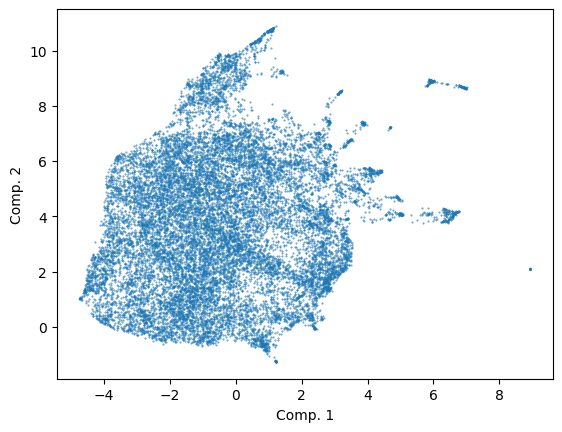

In [30]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(hybrid_df)
umap_reducer_2d = UMAP(n_components=2, n_jobs=-1)
X_umap_2d = umap_reducer_2d.fit_transform(scaled_X)
plt.scatter(
    X_umap_2d[:, 0]
    , X_umap_2d[:, 1]
    , alpha=0.7
    , marker='.'
    , s=1
)

plt.xlabel('Comp. 1')
plt.ylabel('Comp. 2')
plt.show()

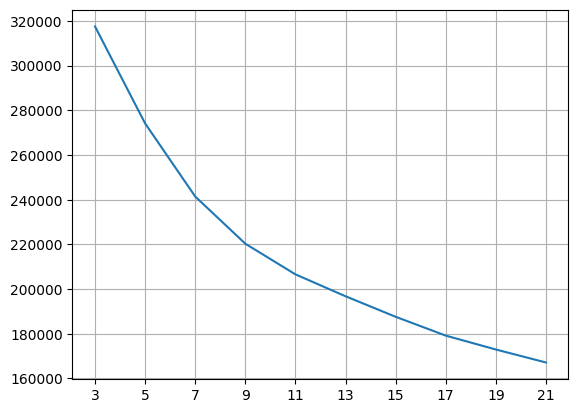

In [31]:
inertias = []
n_clusters = range(3, 22, 2)
for n_cluster in n_clusters: 
    kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=5) 
    kmeans.fit(scaled_X)
    inertias.append(kmeans.inertia_)

plt.plot(n_clusters, inertias)
plt.grid(True)
plt.xticks(n_clusters)
plt.show()

/home/martin/Bureau/heuritech/ds-fashion-insights-takehome/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


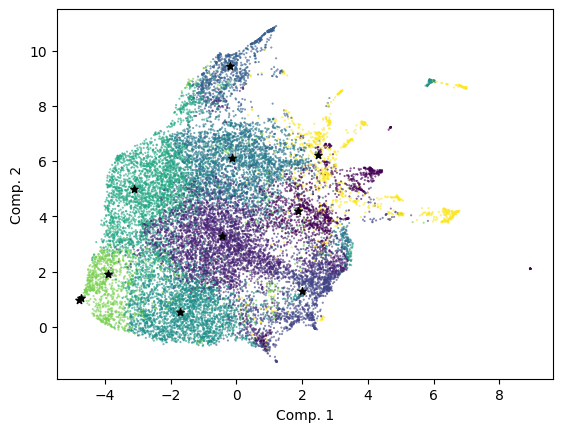

In [32]:
kmeans = KMeans(n_clusters=11, random_state=42, n_init=5) 
kmeans.fit(scaled_X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

centroids_2D = umap_reducer_2d.transform(centroids)
plt.scatter(
    X_umap_2d[:, 0]
    , X_umap_2d[:, 1]
    , c=labels
    , alpha=0.7
    , marker='.'
    , s=1
)

plt.scatter(
    centroids_2D[:, 0]
    , centroids_2D[:, 1]
    , c='black'
    # , alpha=0.7
    , marker='*'
    , s=30
)

plt.xlabel('Comp. 1')
plt.ylabel('Comp. 2')
plt.show()

#### Which approach would you prefer and why? What would be the advantages/limits of each of these methods?

Both approaches have their strengths and weaknesses:

- NMF on image labels is useful for identifying themes in fashion styles, making it great for content categorization. However, its performance depends on the quality and granularity of the labels.
- K-Means on user features is a straightforward way to segment users based on their behaviors but assumes a rigid cluster structure (circular).
- Hybrid approach, where NMF-derived fashion topics are used as additional features for user clustering. This way, we can segment users based on both their engagement patterns and their affinities with specific fashion themes, leading to a more nuanced segmentation.
